In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [4]:
print('Importation des librairies...')
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras.backend as K
import talib
print('Librairies importées')

Importation des librairies...
Librairies importées


In [5]:
# Setting the data
start = pd.to_datetime('2014-01-28')
end = pd.to_datetime('2019-03-28')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')
print('Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés')


# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
df = web.DataReader('GOOG','yahoo',start,end)
#dataframe = dataframe.iloc[:,1:]
df.reset_index(inplace=True)
df.head()

Période d'étude :  1885
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  1508  jours 
Bloc 2 : 377  jours
Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés


,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-01-28,559.237671,551.383789,551.572571,557.876526,4449100.0,557.876526
1,2014-01-29,557.250610,546.157776,555.944092,549.883545,4790600.0,549.883545
2,2014-01-30,572.521301,559.982849,568.800476,564.026550,10248900.0,564.026550
3,2014-01-31,589.436279,571.845703,581.890381,586.669312,11204900.0,586.669312
4,2014-02-03,587.041870,562.347473,585.789978,563.052856,9197600.0,563.052856


In [6]:
df.count()

Date         1301
High         1301
Low          1301
Open         1301
Close        1301
Volume       1301
Adj Close    1301
dtype: int64

In [7]:
df.index.min(), df.index.max()

(0, 1300)

In [8]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-01-28,559.237671,551.383789,551.572571,557.876526,4449100.0,557.876526
1,2014-01-29,557.250610,546.157776,555.944092,549.883545,4790600.0,549.883545
2,2014-01-30,572.521301,559.982849,568.800476,564.026550,10248900.0,564.026550
3,2014-01-31,589.436279,571.845703,581.890381,586.669312,11204900.0,586.669312
4,2014-02-03,587.041870,562.347473,585.789978,563.052856,9197600.0,563.052856


In [9]:
#df['DayOfYear'] = df.index.dayofyear
#df['HourOfDay'] = df.index.hour
#df['MonthOfYear'] = df.index.month
df = df.drop(columns='Close',axis=1)

In [10]:
# Add additional features
df['day']  = df['Date'].dt.weekday
df['week'] = df['Date'].dt.week
df['momentum']  = df['Volume'] * (df['Open'] - df['Adj Close'])
df['avg_price'] = (df['Low'] + df['High'])/2
df['range']     = df['High'] - df['Low']
df['ohlc_price'] = (df['Low'] + df['High'] + df['Open'] + df['Adj Close'])/4
df['oc_diff']    = df['Open'] - df['Adj Close']
#df = df.iloc[:,1:]

In [11]:
df_close = []
df_oc = []
df_hl = []
df_Doc = []
df_Dhl = []

len_df = len(df)
rsi_df = talib.RSI(df['Open'], timeperiod=2)
ema5_df = talib.EMA(df['Open'],timeperiod=5)
ema21_df = talib.EMA(df['Open'],timeperiod=21)

for i in range (0,len_df):
    df_oc.append(float(df.iloc[i,5]) - float(df.iloc[i,3]))
    df_hl.append(float(df.iloc[i,1]) - float(df.iloc[i,2]))

df['oc_eurusd'] = df_oc
df['hl_eurusd'] = df_hl

for i in range (1,len_df):
    b = i - 1
    df_close.append((df.iloc[i,5] - df.iloc[b,3]) / (df.iloc[b,3]+0.0001))
    df_Doc.append((df.iloc[i,6] - df.iloc[b,6]) / (df.iloc[b,4]+0.0001))
    df_Dhl.append((df.iloc[i,7] - df.iloc[b,7]) / (df.iloc[b,5]+0.0001))
df = df.iloc[1:,:]

df['eurusd_close'] = df_close
df['eurusd_Doc'] = df_Doc
df['eurusd_Dhl'] = df_Dhl
df['rsi_eurusd'] = rsi_df
df['ema5_eurusd'] = ema5_df
df['ema21_eurusd'] = ema21_df

df = df.dropna()
df.shape


(1281, 21)

In [13]:
df.head()

,Date,High,Low,Open,Volume,Adj Close,day,week,momentum,avg_price,...,ohlc_price,oc_diff,oc_eurusd,hl_eurusd,eurusd_close,eurusd_Doc,eurusd_Dhl,rsi_eurusd,ema5_eurusd,ema21_eurusd
20,2014-02-26,610.469482,602.958313,608.045227,3990000.0,606.142639,2,9,7.591326e+06,606.713898,...,606.903915,1.902588,-1.902588,7.511169,0.003479,3.453039e-07,0.000000,94.819703,602.367758,584.422936
21,2014-02-27,608.159485,604.572815,605.258362,2536300.0,605.665710,3,9,-1.033158e+06,606.366150,...,605.914093,-0.407349,0.407349,3.586670,-0.003913,2.506266e-07,0.000000,54.362281,603.331292,586.317065
22,2014-02-28,608.139648,599.212708,606.227051,4657300.0,603.897217,4,9,1.085074e+07,603.676178,...,604.369156,2.329834,-2.329834,8.926941,-0.002249,3.942751e-07,0.000000,64.802504,604.296545,588.127064
23,2014-03-03,600.017456,592.218201,599.476013,4236900.0,597.459106,0,10,8.545432e+06,596.117828,...,597.292694,2.016907,-2.016907,7.799255,-0.014463,-8.588667e-07,0.001656,15.471108,602.689701,589.158787
24,2014-03-04,604.071106,600.842102,603.574341,2954400.0,603.529602,1,10,1.321762e+05,602.456604,...,603.004288,0.044739,-0.044739,3.229004,0.006762,2.360216e-07,0.000000,56.072176,602.984581,590.469292


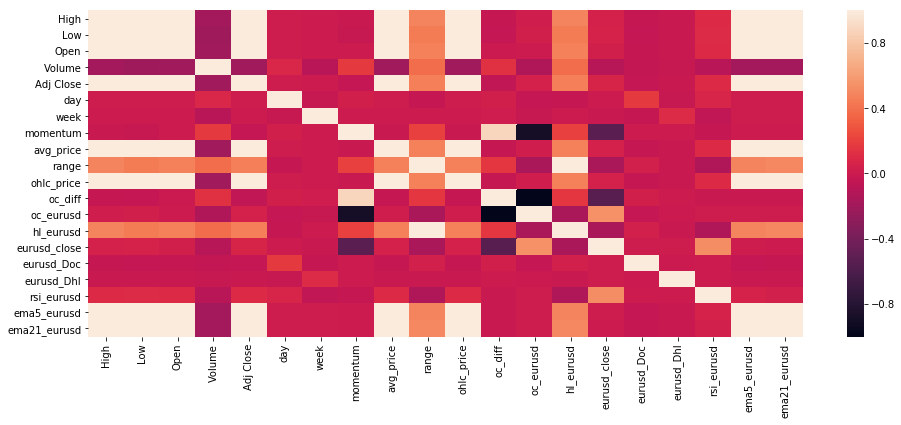

In [12]:
plt.figure(figsize=(16,6))
sns.heatmap(df.corr())
plt.show()

In [15]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
df = df.iloc[:,1:]
dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

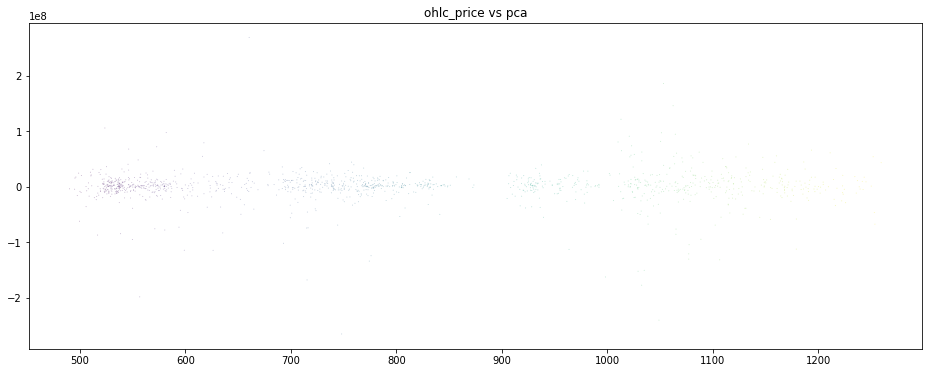

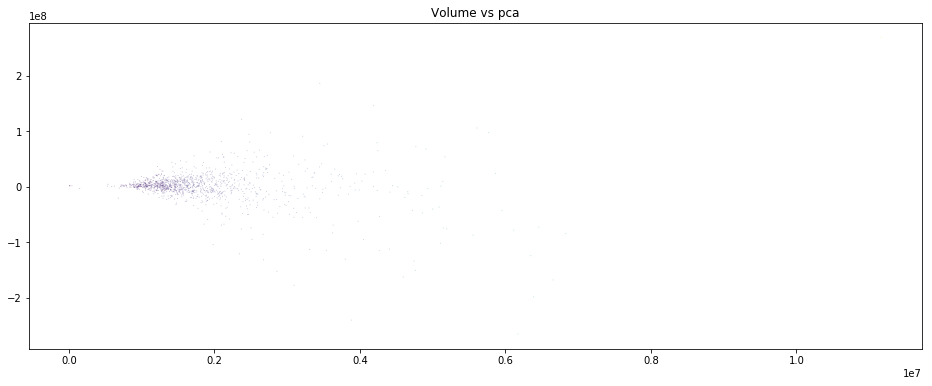

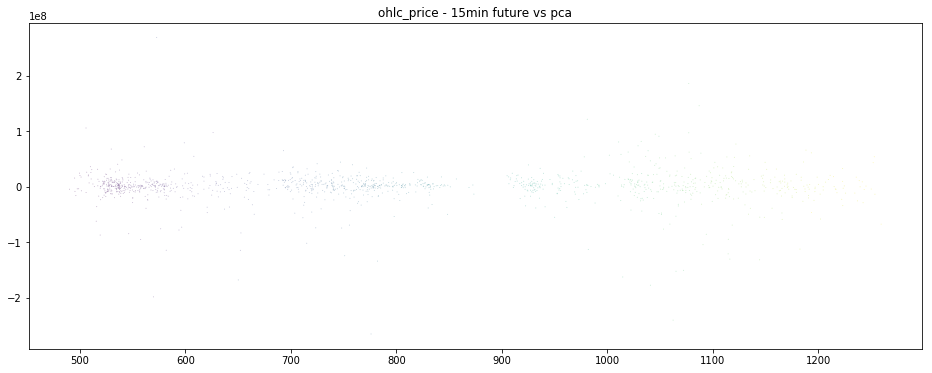

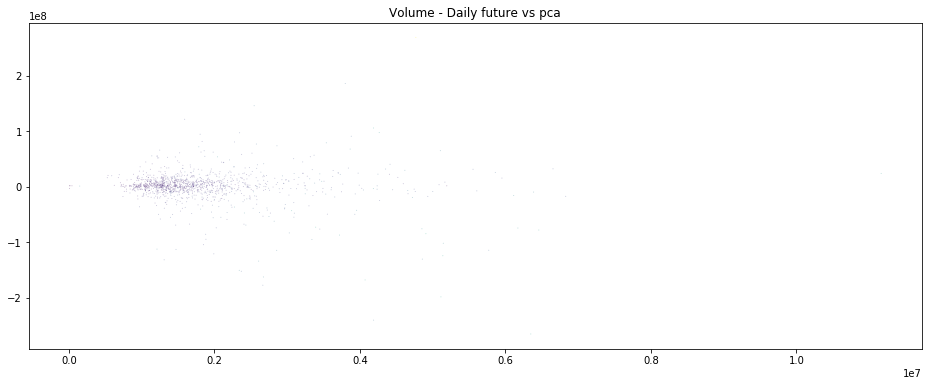

In [16]:
plt.figure(figsize=(16,6))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()

plt.figure(figsize=(16,6))
norm = colors.Normalize(df['Volume'].values.min(), df['Volume'].values.max())
color = cm.viridis(norm(df['Volume'].values))
plt.scatter(df['Volume'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Volume vs pca')
plt.show()

plt.figure(figsize=(16,6))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()

plt.figure(figsize=(16,6))
norm = colors.Normalize(df['Volume'].values.min(), df['Volume'].values.max())
color = cm.viridis(norm(df['Volume'].values))
plt.scatter(df['Volume'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Volume - Daily future vs pca')
plt.show()

In [17]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

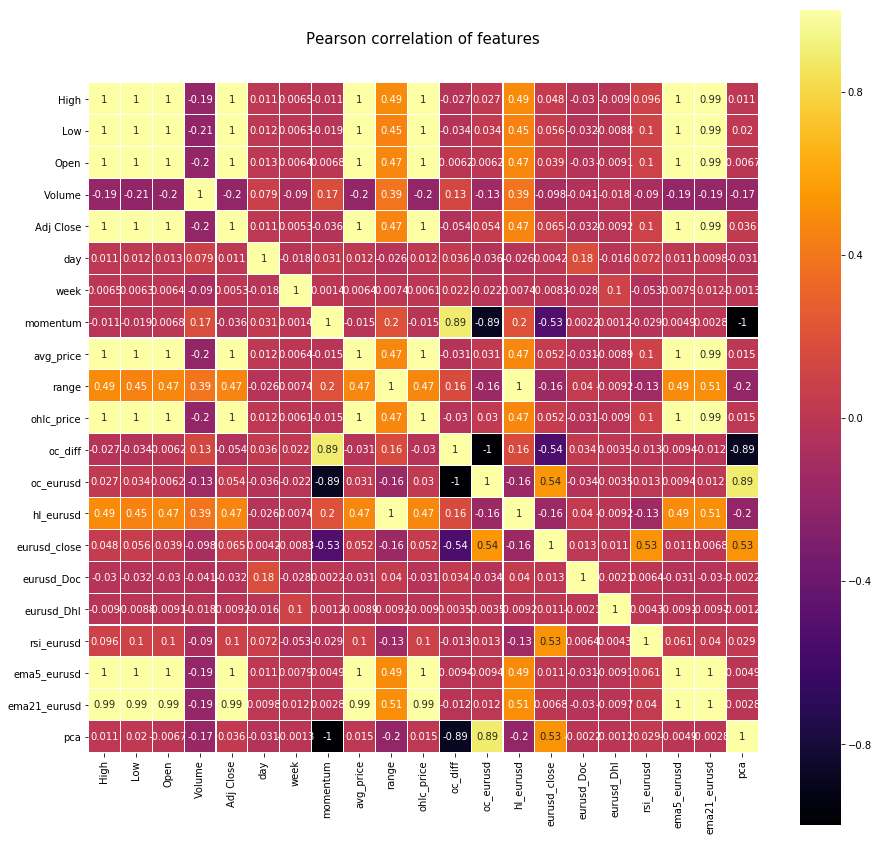

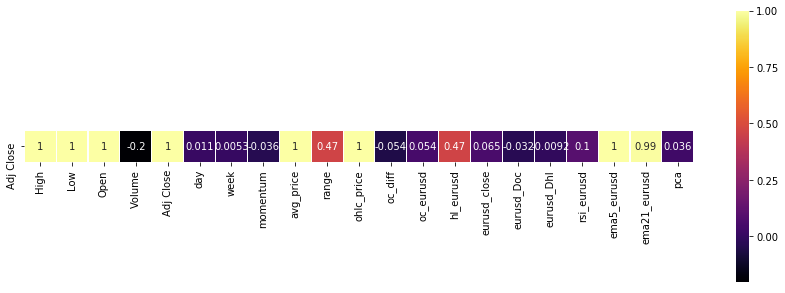

In [18]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'Adj Close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [19]:

# Scale and create datasets
target_index = df.columns.tolist().index('Adj Close')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]
X = np.reshape(X, (X.shape[0], X.shape[2]))

In [20]:
forest = RandomForestRegressor(n_estimators = 200)
forest = forest.fit(X, y)

Feature ranking:
0. Low 1 (0.191380)
1. Adj Close 4 (0.180611)
2. ohlc_price 10 (0.162432)
3. avg_price 8 (0.136084)
4. High 0 (0.129481)
5. Open 2 (0.093657)
6. ema21_eurusd 19 (0.071164)
7. ema5_eurusd 18 (0.033607)
8. Volume 3 (0.000268)
9. rsi_eurusd 17 (0.000207)
10. eurusd_close 14 (0.000197)
11. week 6 (0.000189)
12. eurusd_Doc 15 (0.000153)
13. momentum 7 (0.000092)
14. pca 20 (0.000090)
15. range 9 (0.000082)
16. hl_eurusd 13 (0.000082)
17. oc_eurusd 12 (0.000067)
18. oc_diff 11 (0.000067)
19. day 5 (0.000062)


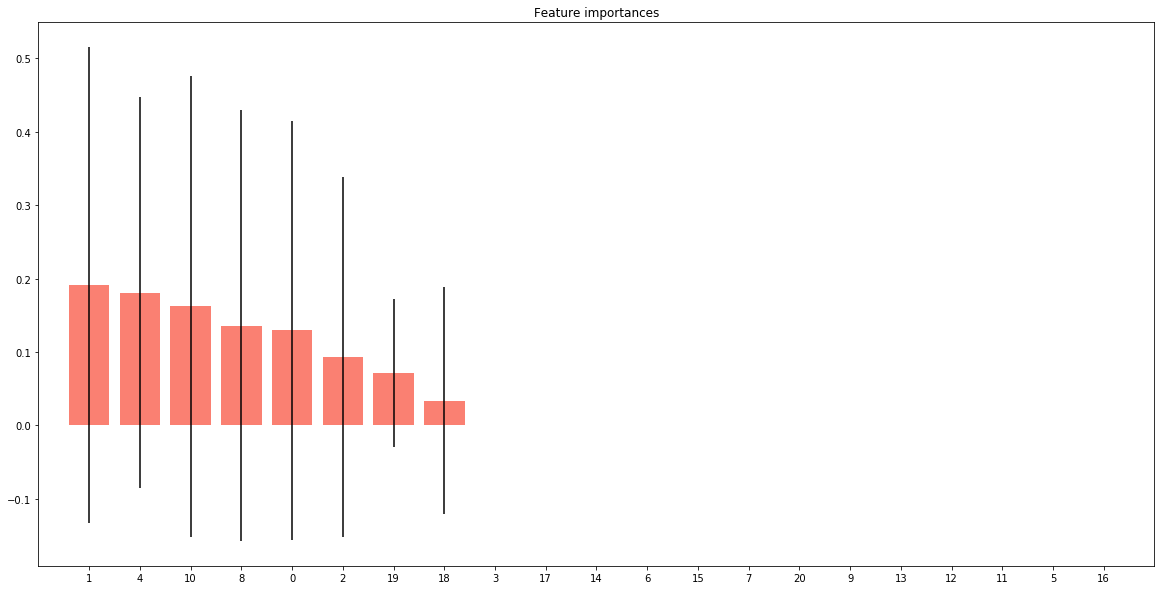

In [21]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

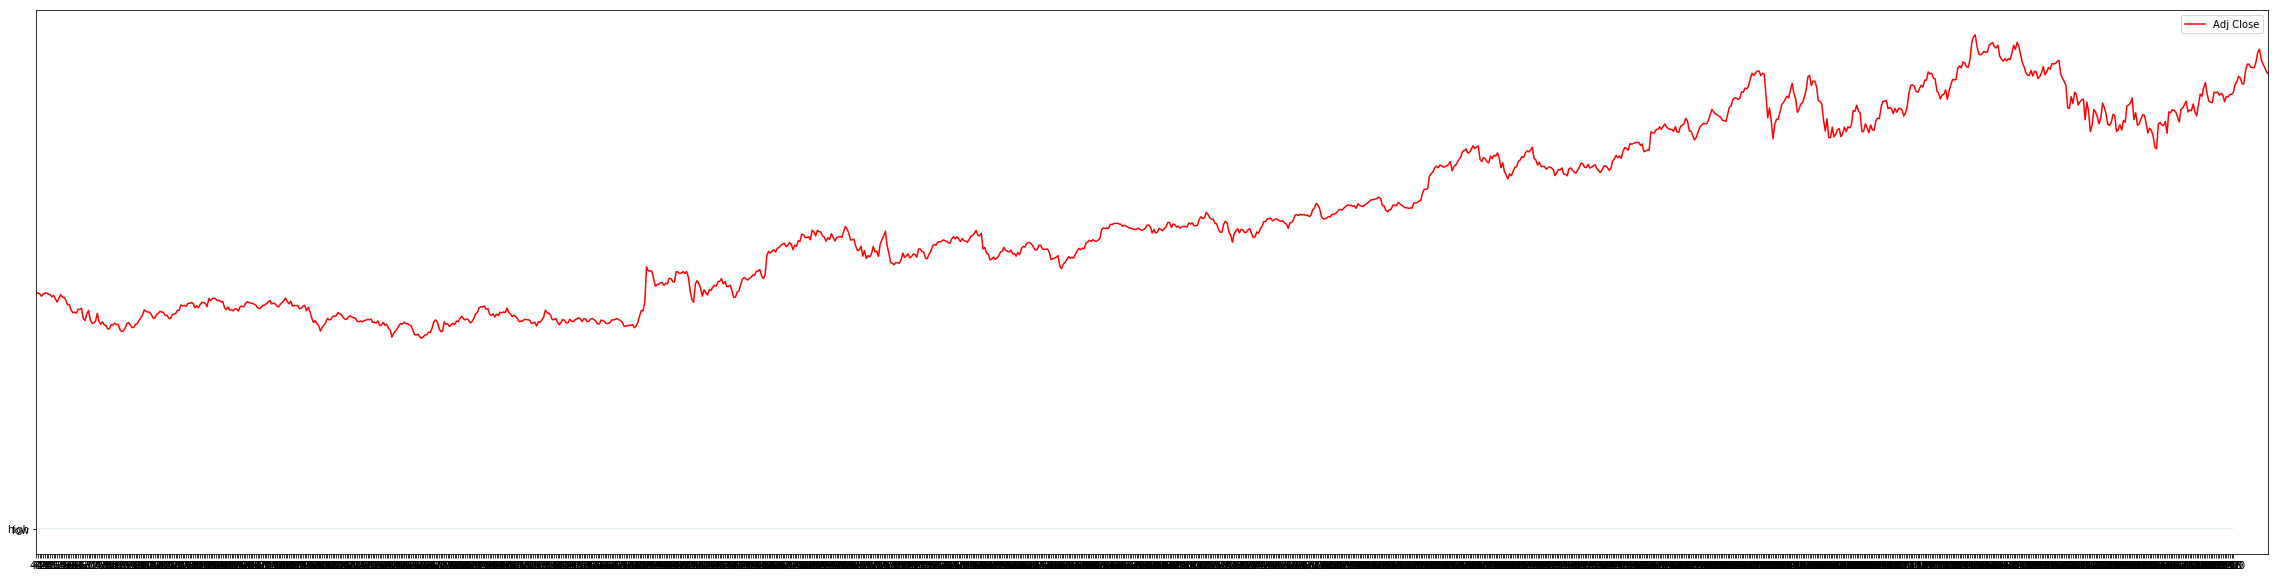

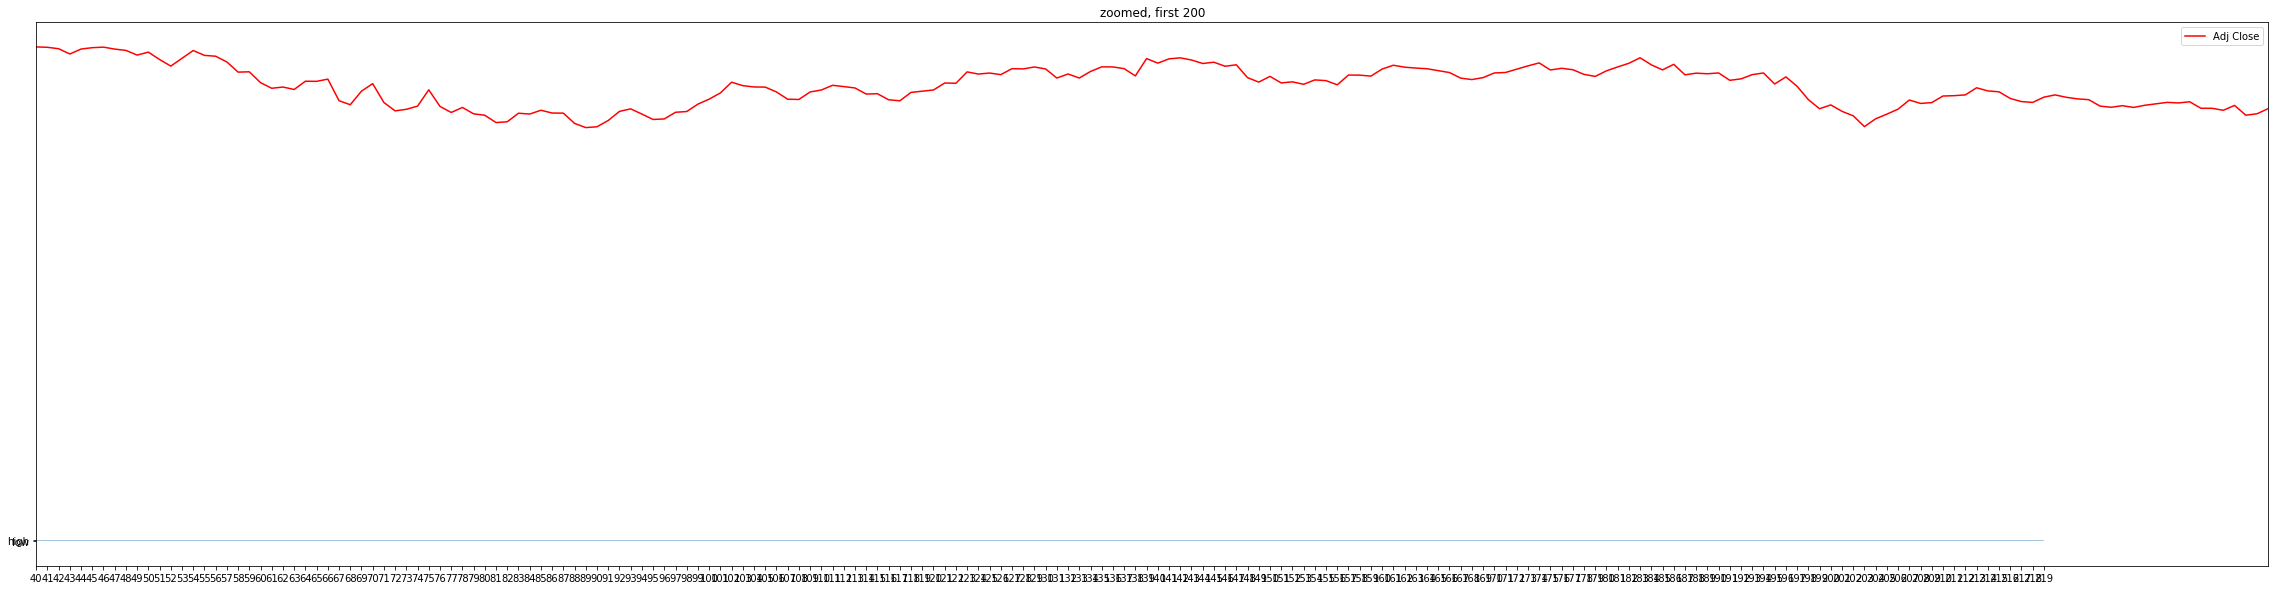

In [22]:
ax = df.plot( y='Adj Close', c='red', figsize=(40,10),)
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low',y2='high', data=df, alpha=0.4)
plt.show()

p = df[:200].copy()
ax = p.plot( y='Adj Close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

In [23]:
# Scale and create datasets
target_index = df.columns.tolist().index('Adj Close')
high_index = df.columns.tolist().index('High')
low_index = df.columns.tolist().index('Low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['Adj Close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=20)
y = y[:,target_index]

In [24]:
# Set training data size
# We have a large enough dataset. So divid into 90% training / 10% test sets
train_size = int(len(X) * 0.9)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae', 'mse'])
print(model.summary())

W0522 12:06:36.883066 4648220096 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0522 12:06:36.900345 4648220096 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0522 12:06:36.902642 4648220096 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0522 12:06:37.359972 4648220096 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorfl

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            3360      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total para

In [26]:
# Save the best weight during training.
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=20, batch_size=5, verbose=1, callbacks=callbacks_list, validation_split=0.1)

W0522 12:06:43.428948 4648220096 deprecation.py:323] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0522 12:06:45.534924 4648220096 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1020 samples, validate on 114 samples
Epoch 1/20
1020/1020 [==============================] - 13s 13ms/step - loss: 0.0761 - acc: 9.8039e-04 - mean_absolute_error: 0.2064 - mean_squared_error: 0.0761 - val_loss: 0.1716 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.4052 - val_mean_squared_error: 0.1716

Epoch 00001: val_mean_squared_error improved from inf to 0.17160, saving model to weights.best.hdf5
Epoch 2/20
1020/1020 [==============================] - 10s 10ms/step - loss: 0.0059 - acc: 9.8039e-04 - mean_absolute_error: 0.0525 - mean_squared_error: 0.0059 - val_loss: 0.0273 - val_acc: 0.0088 - val_mean_absolute_error: 0.1434 - val_mean_squared_error: 0.0273

Epoch 00002: val_mean_squared_error improved from 0.17160 to 0.02732, saving model to weights.best.hdf5
Epoch 3/20
1020/1020 [==============================] - 10s 10ms/step - loss: 0.0020 - acc: 9.8039e-04 - mean_absolute_error: 0.0339 - mean_squared_error: 0.0020 - val_loss: 0.0142 - val_acc: 0.0088 - val_mean_a

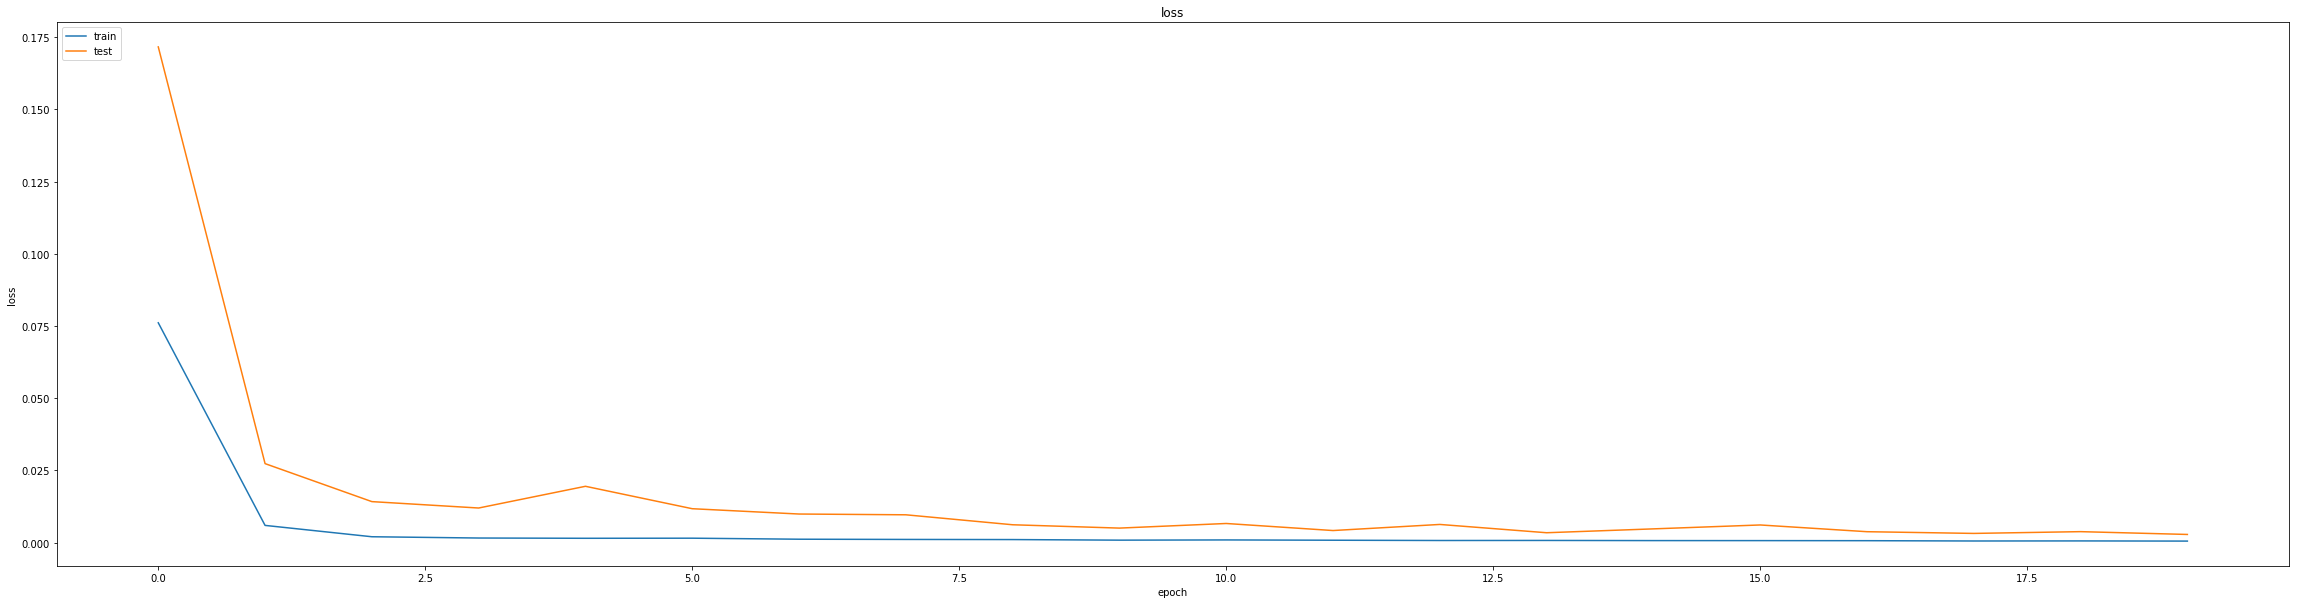

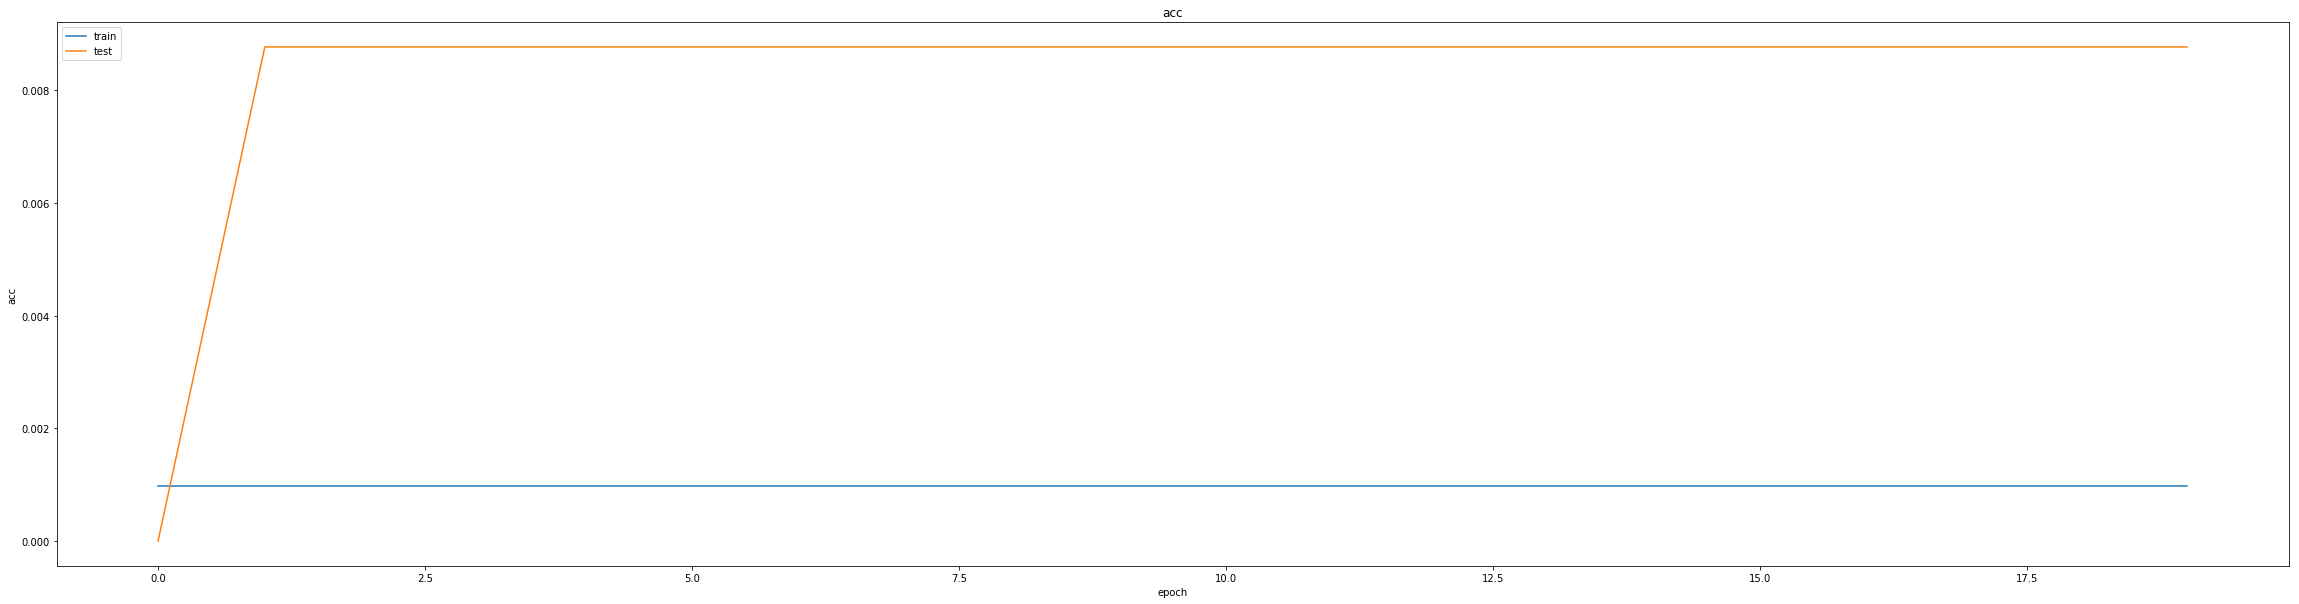

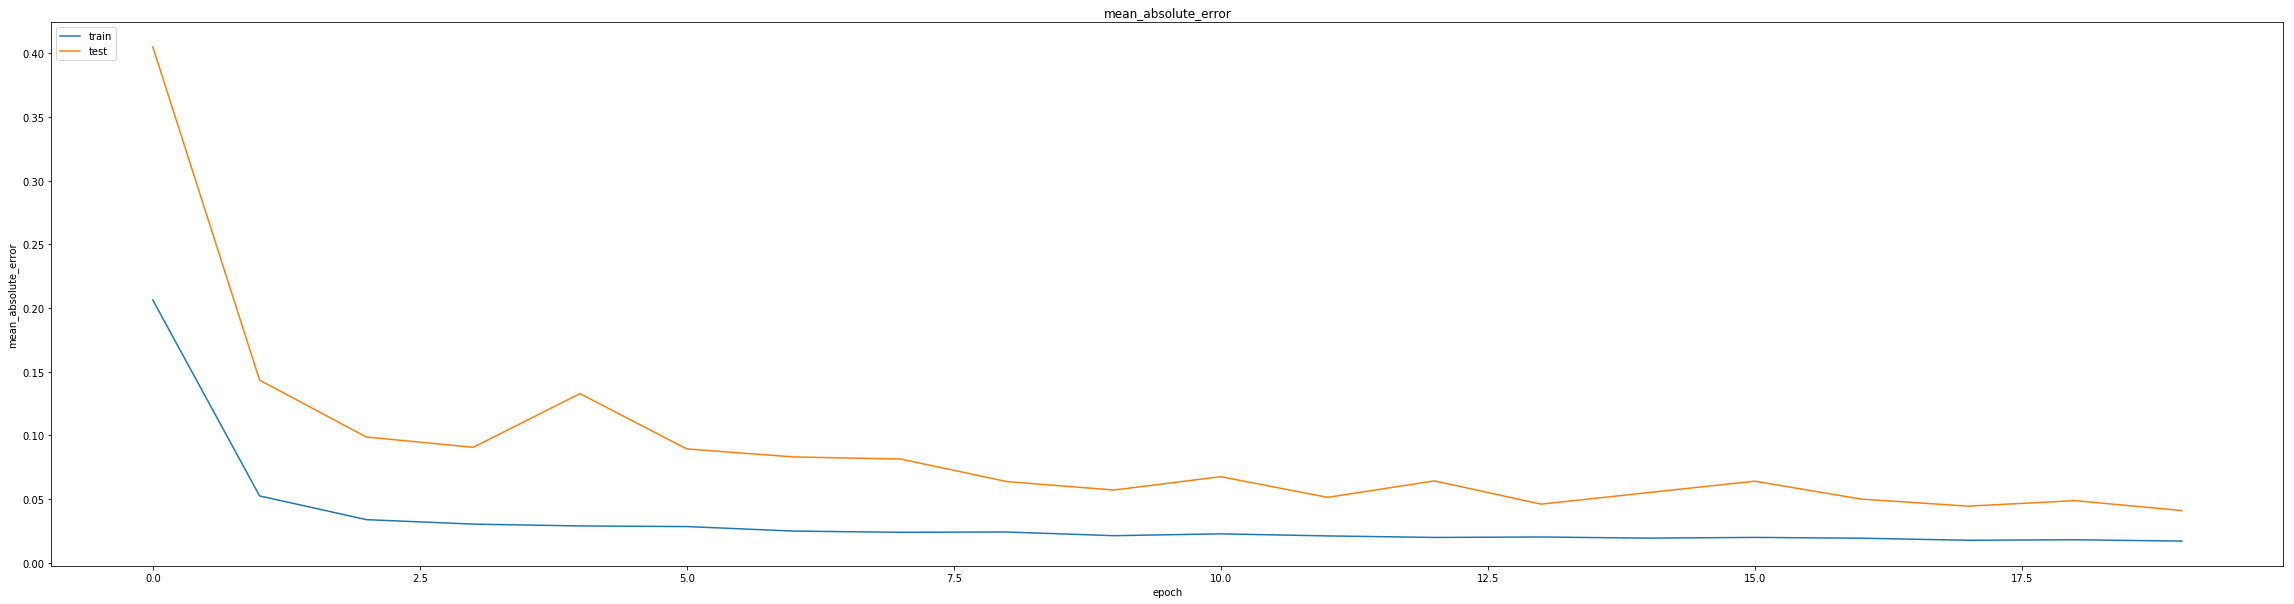

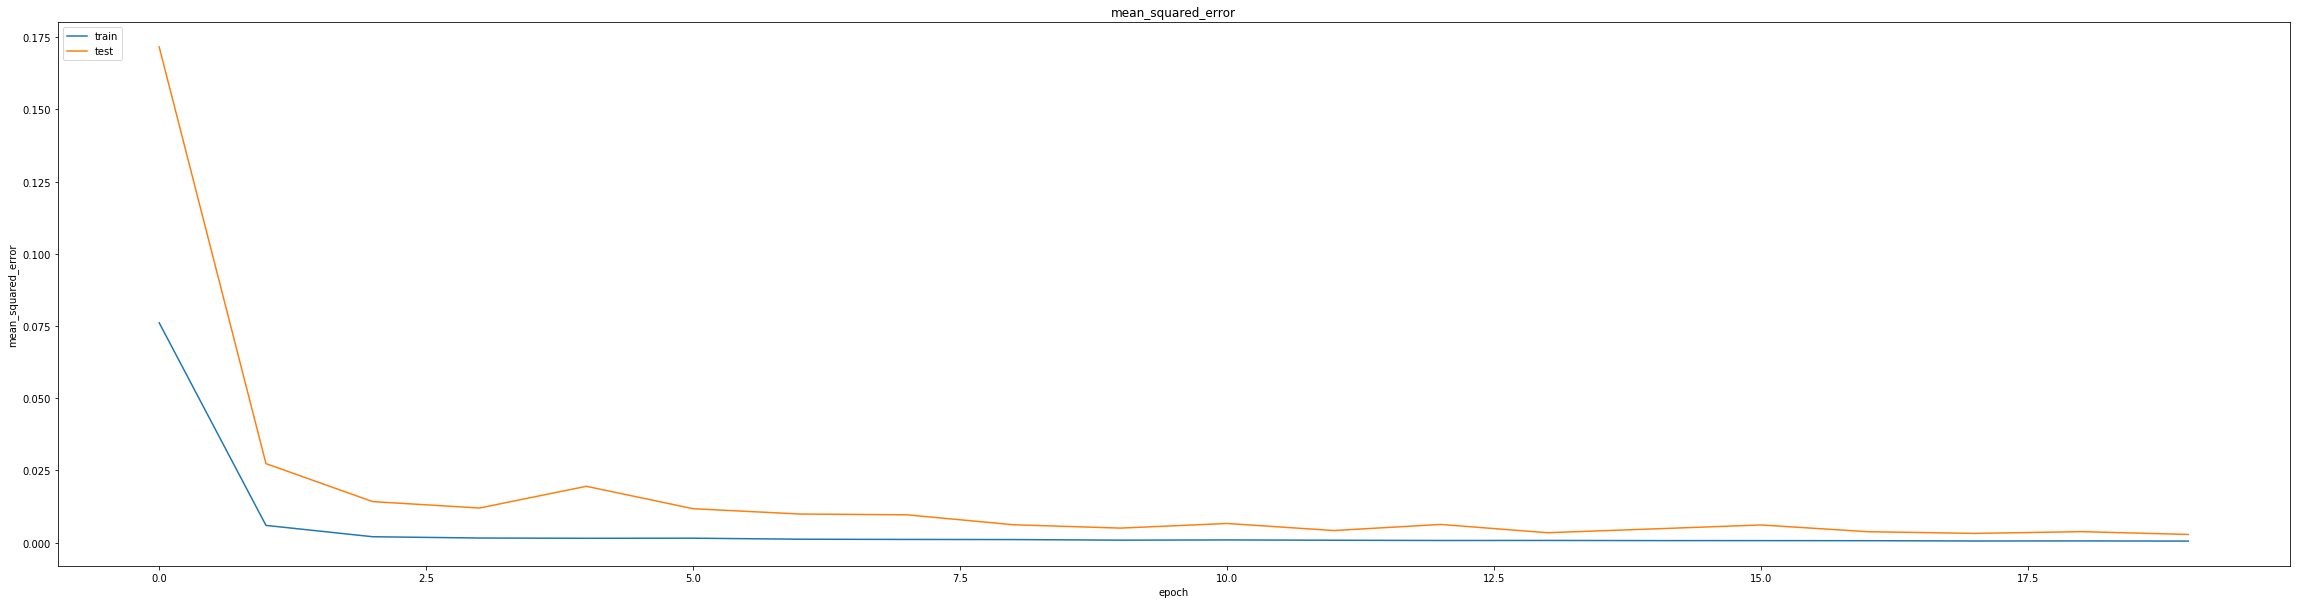

In [27]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k and k != 'lr':
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [28]:
min(history.history['val_mean_absolute_error'])

0.04102055606710022

In [29]:
# Baby the model a bit
# Load the weight that worked the best
model.load_weights("weights.best.hdf5")

# Train again with decaying learning rate

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=epoch, batch_size=5, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Train on 1020 samples, validate on 114 samples
Epoch 1/20
1020/1020 [==============================] - 9s 9ms/step - loss: 5.5358e-04 - acc: 9.8039e-04 - mean_absolute_error: 0.0180 - mean_squared_error: 5.5358e-04 - val_loss: 0.0038 - val_acc: 0.0088 - val_mean_absolute_error: 0.0487 - val_mean_squared_error: 0.0038

Epoch 00001: val_mean_squared_error did not improve from 0.00280
Epoch 2/20
1020/1020 [==============================] - 9s 9ms/step - loss: 5.0409e-04 - acc: 9.8039e-04 - mean_absolute_error: 0.0169 - mean_squared_error: 5.0409e-04 - val_loss: 0.0040 - val_acc: 0.0088 - val_mean_absolute_error: 0.0496 - val_mean_squared_error: 0.0040

Epoch 00002: val_mean_squared_error did not improve from 0.00280
Epoch 3/20
lr changed to 0.0009000000427477062
1020/1020 [==============================] - 9s 9ms/step - loss: 4.8370e-04 - acc: 9.8039e-04 - mean_absolute_error: 0.0165 - mean_squared_error: 4.8370e-04 - val_loss: 0.0033 - val_acc: 0.0088 - val_mean_absolute_error: 0.0466 - 

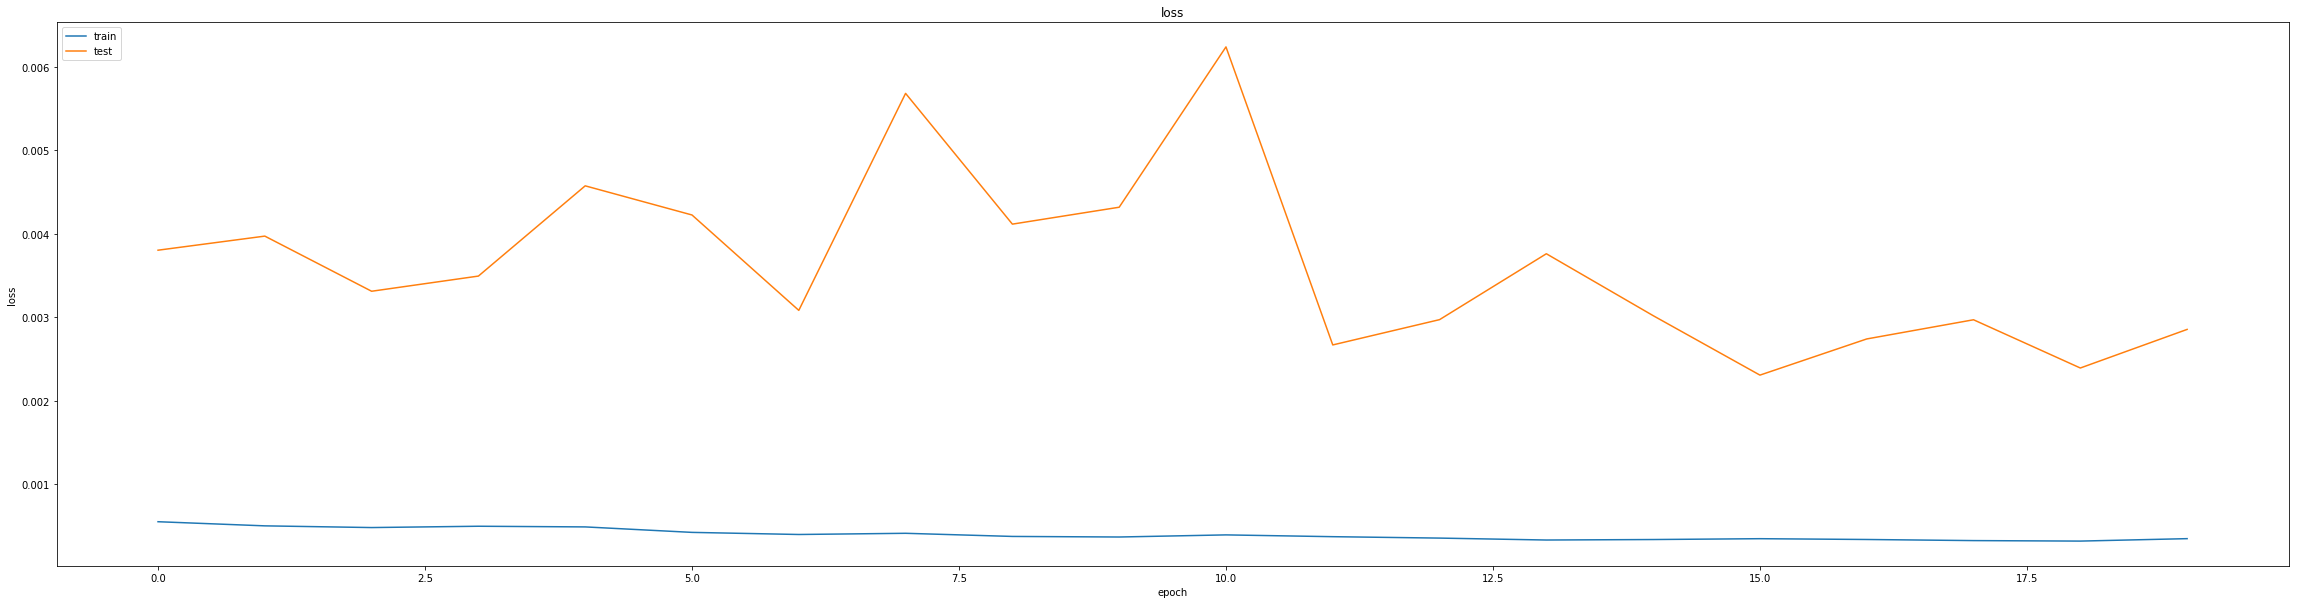

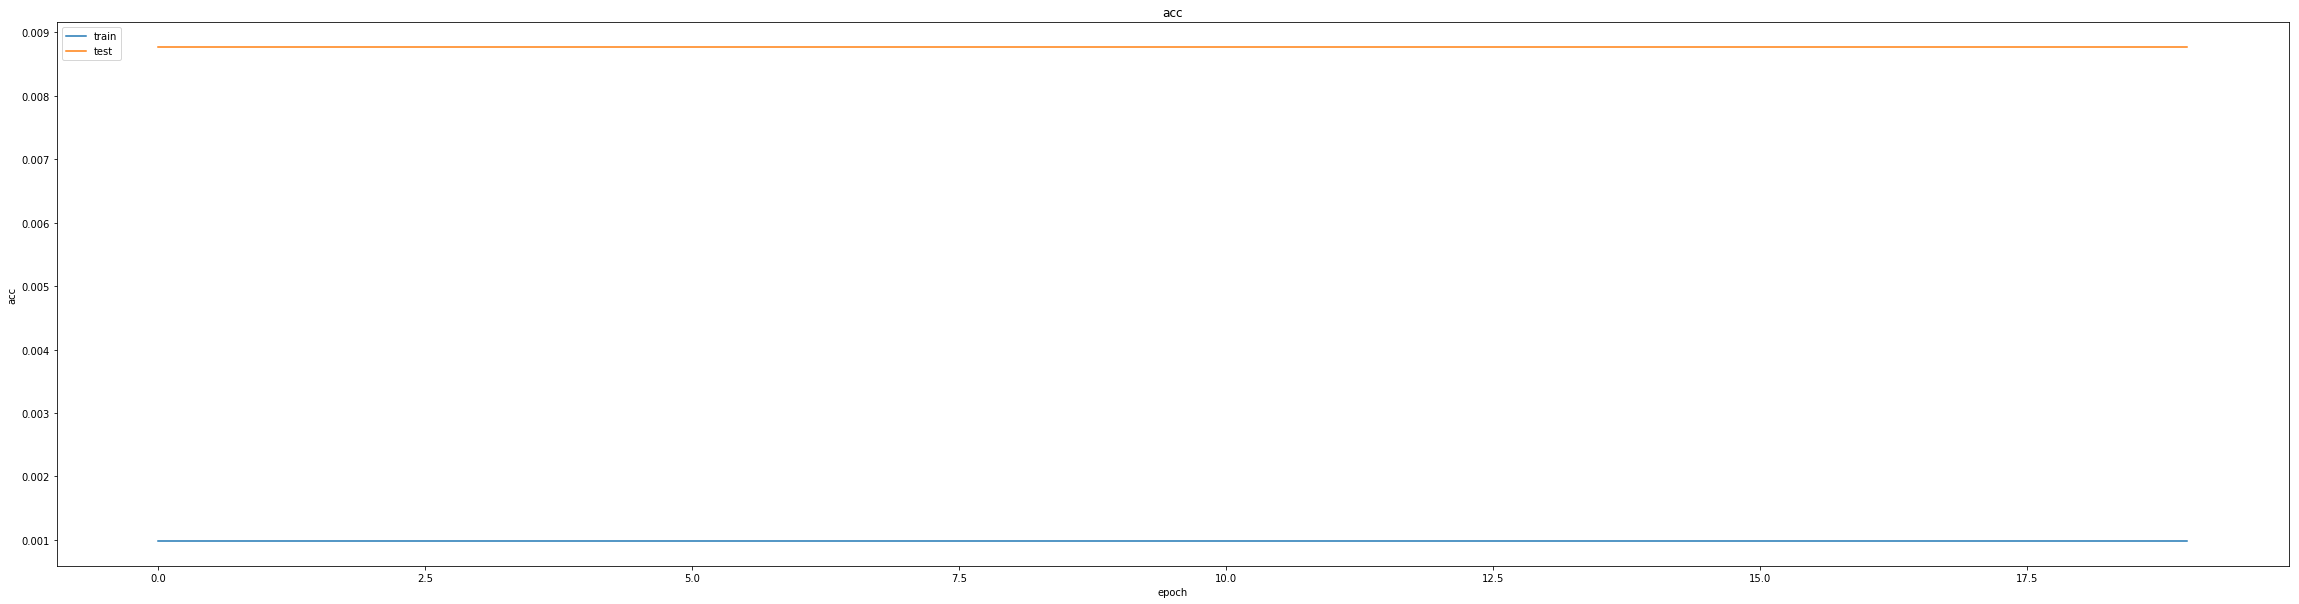

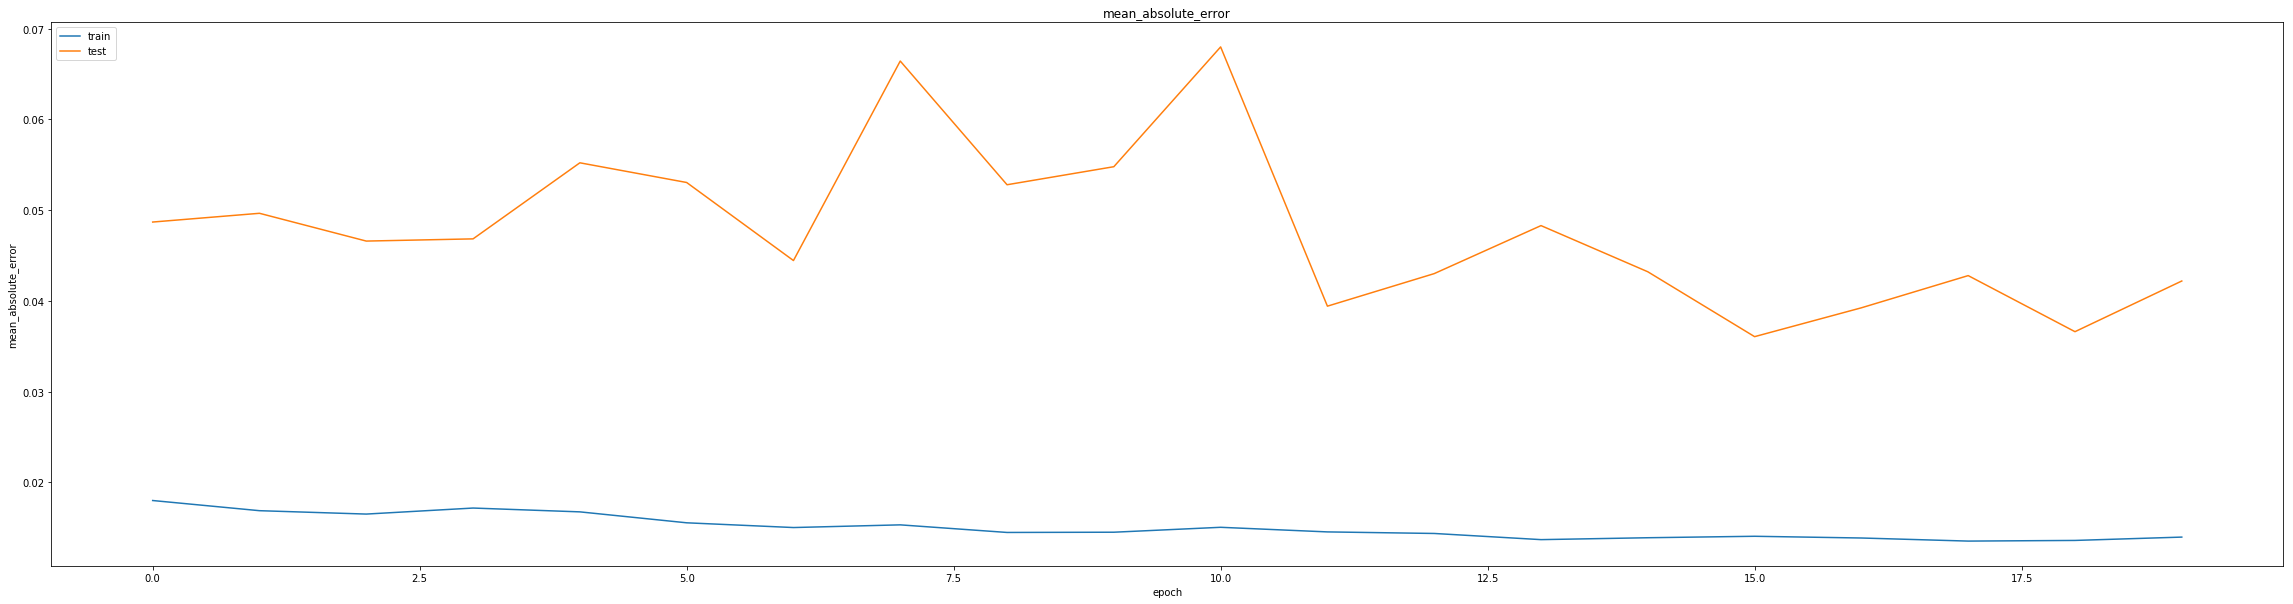

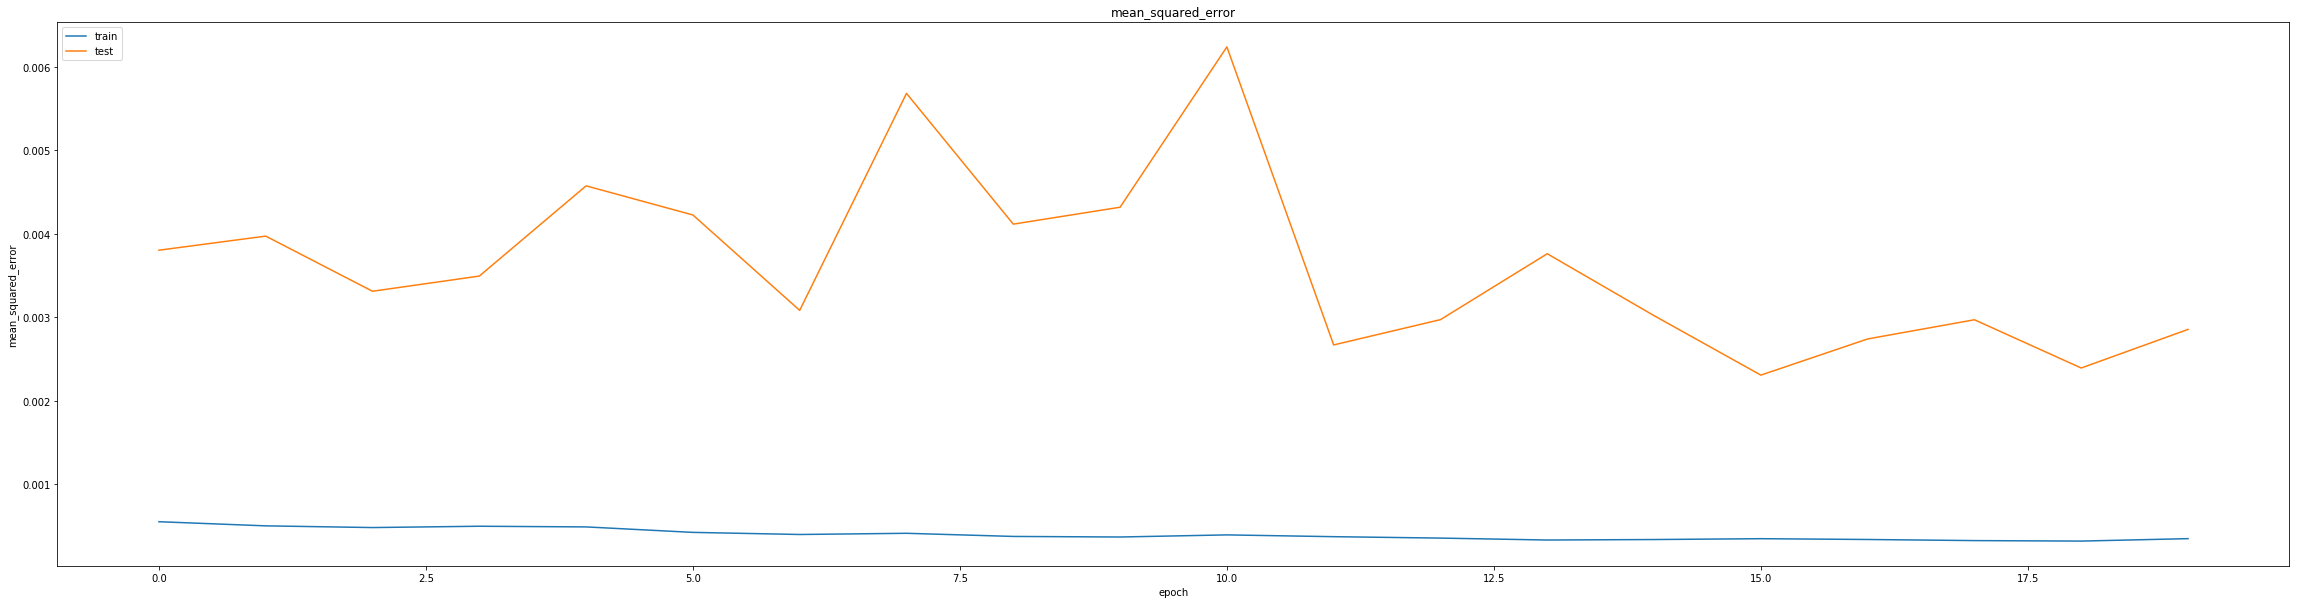

In [30]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k and k!='lr':
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [31]:
min(history.history['val_mean_absolute_error'])

0.036049318303795236

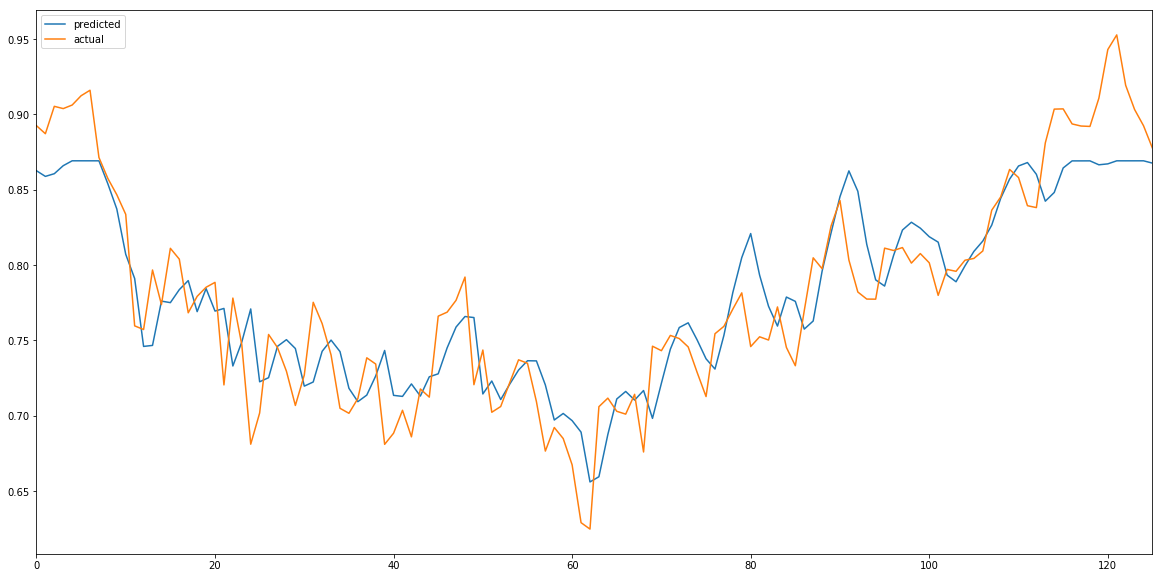

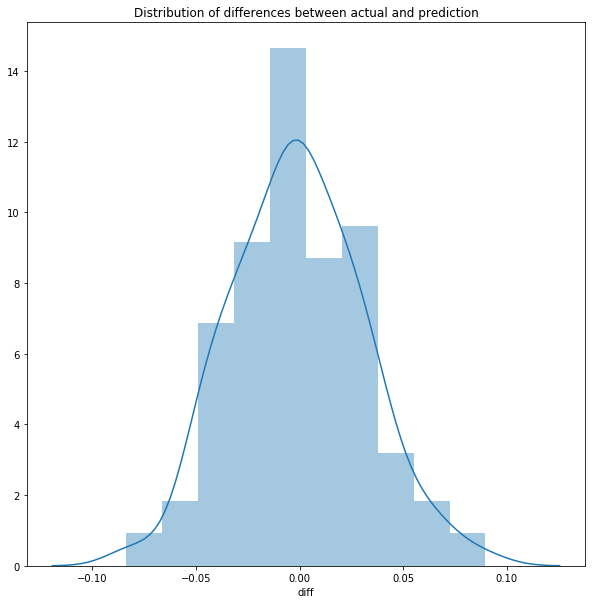

MSE :  0.0009851505234312215
MAE :  0.024939540359709


count    126.000000
mean      -0.000970
std        0.031497
min       -0.083563
25%       -0.023625
50%       -0.002120
75%        0.020885
max        0.089757
Name: diff, dtype: float64

In [32]:

# Benchmark
model.load_weights("weights.best.hdf5")

pred = model.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

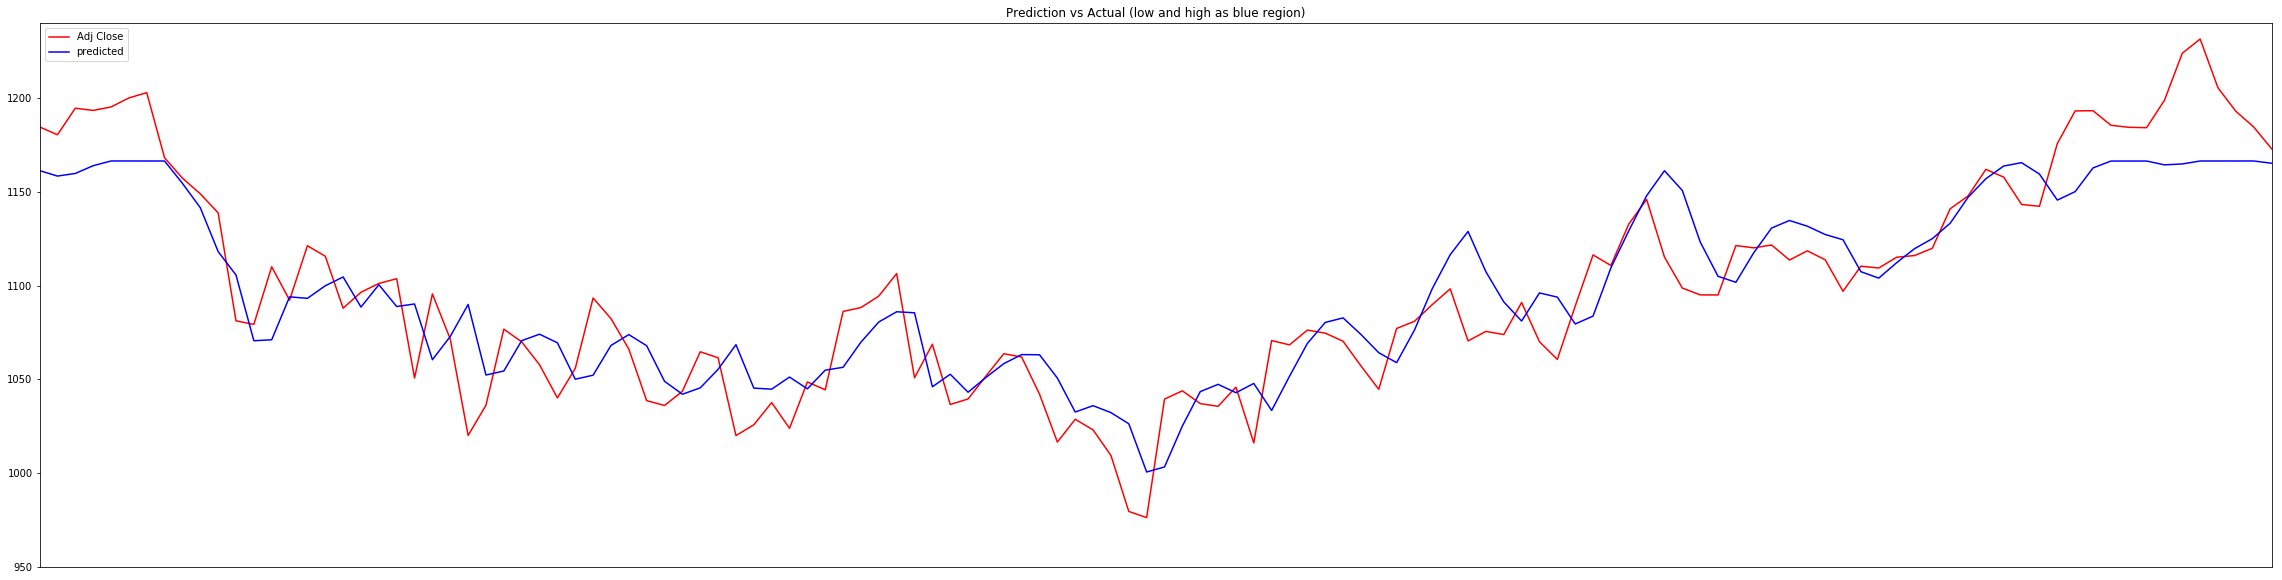

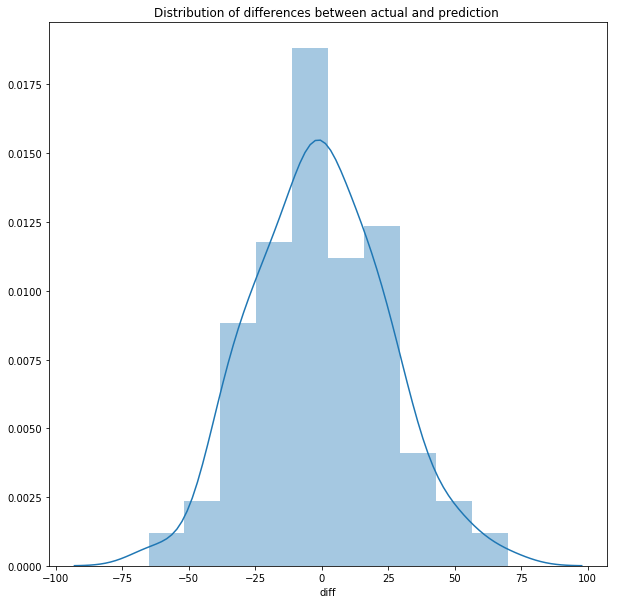

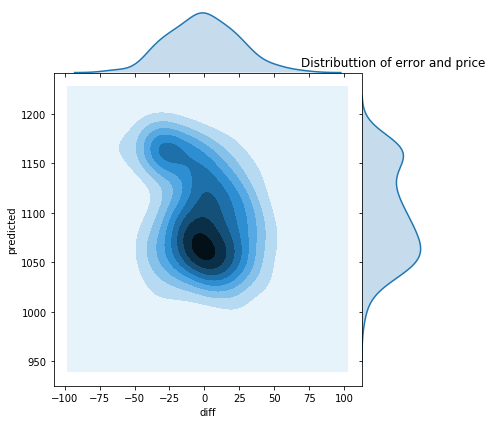

MSE :  597.0254793257585
MAE :  19.414830767919145


count    126.000000
mean      -0.754915
std       24.519935
min      -65.051636
25%      -18.391510
50%       -1.650391
75%       16.258514
max       69.873901
Name: diff, dtype: float64

In [33]:
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['Adj Close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['Low', 'High']], right_index=True, left_index=True)

ax = predictions.plot(y='Adj Close', c='red', figsize=(40,10))
ax = predictions.plot(y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.ylim(950,1240)
plt.fill_between(x=index, y1='Low', y2='High', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['Adj Close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['Adj Close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['Adj Close'].values))
predictions['diff'].describe()

In [34]:
predictions.min()#,predictions.min()

predicted    1000.580139
Adj Close     976.219910
Low           970.109985
High         1003.539978
diff          -65.051636
dtype: float64

In [36]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'val_mean_squared_error', 'loss', 'acc', 'mean_absolute_error', 'mean_squared_error', 'lr'])